## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

## Data Pre-Processing

### Initializing CSV

In [2]:
# Load data from CSV file
file_path = "New Data.csv"
raw_data = pd.read_csv(file_path)


C:\Users\rishi\AppData\Local\Temp\ipykernel_3860\2253595201.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(file_path)


In [3]:
# Remove the 2nd and 3rd rows (indices 1 and 2)
raw_data.drop([0, 1], inplace=True)
# Reset the index
raw_data.reset_index(drop=True, inplace=True)


last_reading=raw_data["Pressure of D "].iloc[-1]
print(last_reading)

raw_data=raw_data[:-1]

184.9


In [4]:
# Combine 'Date' and 'Time' columns into a new 'DateTime' column
raw_data['DateTime'] = pd.to_datetime(raw_data['Date'] + ' ' + raw_data['Time'], format='%m.%d.%Y %H:%M', errors='coerce')


In [5]:
# Fill missing values in all columns by taking the average of the previous and next values
raw_data = raw_data.interpolate(method='linear', limit_direction='both')


C:\Users\rishi\AppData\Local\Temp\ipykernel_3860\56133601.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  raw_data = raw_data.interpolate(method='linear', limit_direction='both')


In [6]:
# Convert columns 2-14 to numeric
cols_to_numeric = raw_data.columns[2:15]  # Columns 2 to 14 (exclusive of 15)
raw_data[cols_to_numeric] = raw_data[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Convert 'Date' column to datetime
raw_data['Date'] = pd.to_datetime(raw_data['Date'], format='%d.%m.%Y', errors='coerce')

# Display the updated DataFrame info
print(raw_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420550 entries, 0 to 420549
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            420550 non-null  datetime64[ns]
 1   Time            420550 non-null  object        
 2   Temp of A       420549 non-null  float64       
 3   Temp of B       420548 non-null  float64       
 4   Temp of C       420548 non-null  float64       
 5   Pressure of B   420547 non-null  float64       
 6   Pressure of C   420547 non-null  float64       
 7   Flowrate        420546 non-null  float64       
 8   Level           420550 non-null  float64       
 9   Weight          420548 non-null  float64       
 10  H2OC            420550 non-null  float64       
 11  Mass Flowrate   420547 non-null  float64       
 12  wv              420550 non-null  float64       
 13  COT             420550 non-null  int64         
 14  Pressure of D   420550 non-null  flo

In [7]:
# Assuming `raw_data` is your DataFrame
raw_data['DateTime'] = pd.to_datetime(raw_data['DateTime'])

In [8]:
# Set the "DateTime" column as the index
raw_data.set_index('DateTime', inplace=True)

In [9]:
print(raw_data)

                          Date      Time  Temp of A  Temp of B  Temp of C  \
DateTime                                                                    
2009-01-01 00:10:00 2009-01-01     00:10      -8.02     265.40      -8.90   
2009-01-01 00:20:00 2009-01-01     00:20      -8.41     265.01      -9.28   
2009-01-01 00:30:00 2009-01-01     00:30      -8.51     264.91      -9.31   
2009-01-01 00:40:00 2009-01-01     00:40      -8.31     265.12      -9.07   
2009-01-01 00:50:00 2009-01-01     00:50      -8.27     265.15      -9.04   
...                        ...       ...        ...        ...        ...   
2009-10-01 23:50:00 2016-12-31  23:10:00      -3.93     269.23      -8.09   
2009-10-01 23:50:00 2016-12-31  23:20:00      -4.05     269.10      -8.13   
2009-10-01 23:50:00 2016-12-31  23:30:00      -3.35     269.81      -8.06   
2009-10-01 23:50:00 2016-12-31  23:40:00      -3.16     270.01      -8.21   
2009-10-01 23:50:00 2016-12-31  23:50:00      -4.23     268.94      -8.53   

### Data splitting for train and test

In [10]:
# Selecting columns by index (assuming columns are counted from 1)
target_col = 14

# Extracting the target and parameter variables
target_variable = raw_data.iloc[:, target_col]  

print(target_variable)


# Splitting the data into train and test sets
train_size = int(len(target_variable) * 0.8)
train_data, test_data = target_variable[:train_size], target_variable[train_size:]

DateTime
2009-01-01 00:10:00    152.3
2009-01-01 00:20:00    136.1
2009-01-01 00:30:00    171.6
2009-01-01 00:40:00    198.0
2009-01-01 00:50:00    214.3
                       ...  
2009-10-01 23:50:00    202.6
2009-10-01 23:50:00    240.0
2009-10-01 23:50:00    234.3
2009-10-01 23:50:00    215.2
2009-10-01 23:50:00    225.8
Name: Pressure of D , Length: 420550, dtype: float64


C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an ex

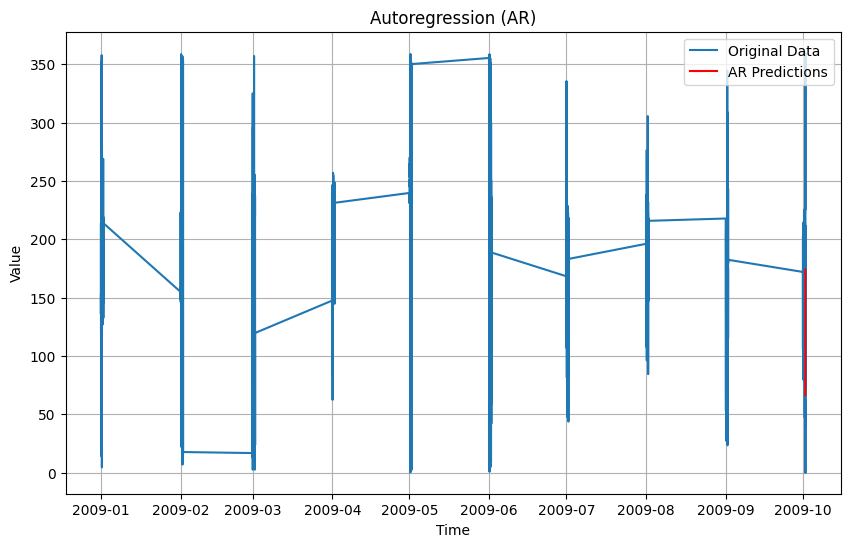

In [11]:


# Fit an Autoregression model
model = AutoReg(train_data, lags=1)  # AR model with lag 1
model_fit = model.fit()

# Predictions
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(target_variable.index, target_variable, label='Original Data')
plt.plot(test_data.index, predictions, color='red', label='AR Predictions')
plt.title('Autoregression (AR)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# Differencing

DateTime
2009-01-01 00:10:00     NaN
2009-01-01 00:20:00   -16.2
2009-01-01 00:30:00    35.5
2009-01-01 00:40:00    26.4
2009-01-01 00:50:00    16.3
Name: Pressure of D , dtype: float64


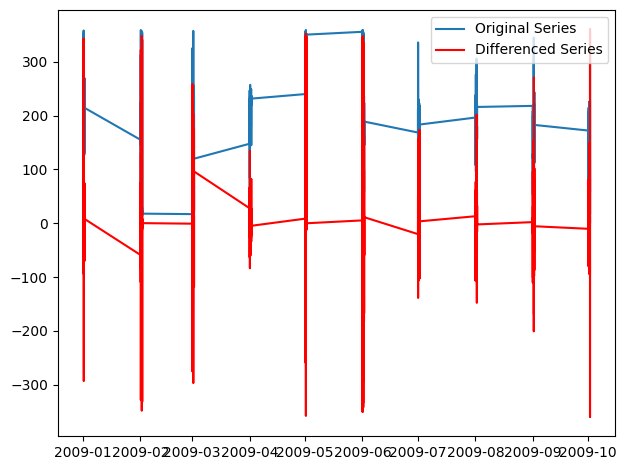

In [12]:
# Step 5: Perform differencing
differenced_series = target_variable.diff()

# Display the first few rows of the differenced series
print(differenced_series.head())

# Step 6: Plot the original and differenced series
plt.figure()
# Plot original series
plt.plot(target_variable, label='Original Series')
# Plot differenced series
plt.plot(differenced_series, label='Differenced Series', color='red')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Moving Averages

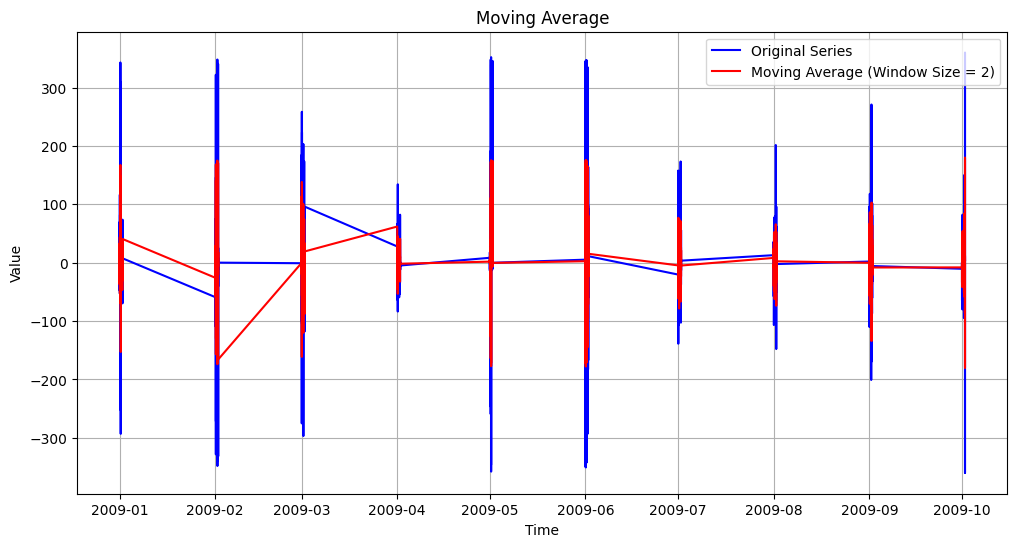

In [13]:
# Step 5: Calculate moving average
window_size = 2  # Example window size for moving average
moving_avg = differenced_series.rolling(window=window_size).mean()

# Step 6: Plot the original series and moving average
plt.figure(figsize=(12, 6))
plt.plot(differenced_series, label='Original Series', color='blue')
plt.plot(moving_avg, label=f'Moving Average (Window Size = {window_size})', color='red')
plt.title('Moving Average')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


# ARIMA

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model
order = (1, 2, 10)  # ARIMA parameters: p=1 (lag order), d=1 (degree of differencing), q=1 (order of moving average)
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Predictions
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, typ='levels')

# Calculate and print the Mean Squared Error
mse = mean_squared_error(test_data, predictions)
print(f'Mean Squared Error (ARIMA): {mse}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(target_variable.index, target_variable, label='Original Data')
plt.plot(test_data.index, predictions, color='red', label='ARIMA Predictions')
plt.title('Autoregressive Integrated Moving Average (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

MemoryError: Unable to allocate 434. MiB for an array with shape (13, 13, 336440) and data type float64

## Forecasting steps

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming model_fit is your fitted ARIMA model

# Example: Specify a specific date for prediction
prediction_date = pd.to_datetime('2017-01-01')
 
# Predict for the specific date
forecast_result = model_fit.forecast(steps=1)  


# Print or use the forecasted value
print(f'Forecasted value for {prediction_date}: {forecast_result}')
